In [2]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
# import pytensor as pt
# import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit

import os


import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.special import expit, logsumexp
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
from numpyro.util import set_host_device_count
from numpyro.contrib.control_flow import scan
from numpyro.ops.indexing import Vindex
from tqdm import tqdm
from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
import pymc_experimental as pmx

import multiprocessing
import socket

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.4
Running on PyMC-experimental v0.0.17
Running on NumPyro v0.14.0
Running on Pyro v1.9.0+f02dfb9
Running on JAX v0.4.25


In [3]:
# Set CPU for JAX
# nchains = multiprocessing.cpu_count()/2
# print("nchains in total are", nchains*2, "; we'll use ", nchains)


# jax.config.update('jax_platform_name', 'cpu')
# platform = jax.lib.xla_bridge.get_backend().platform.casefold()
# print("Platform: ", platform)
# host_name = socket.gethostname()
# localhost_ = socket.gethostbyname(host_name)
# print(localhost_)

# jax.distributed.initialize(coordinator_address="localhost", num_processes=4, process_id=1)
# print(jax.device_count())
# print(jax.local_device_count())

# set_host_device_count(nchains)
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))




[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [4]:
RANDOM_SEED = 892357143
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

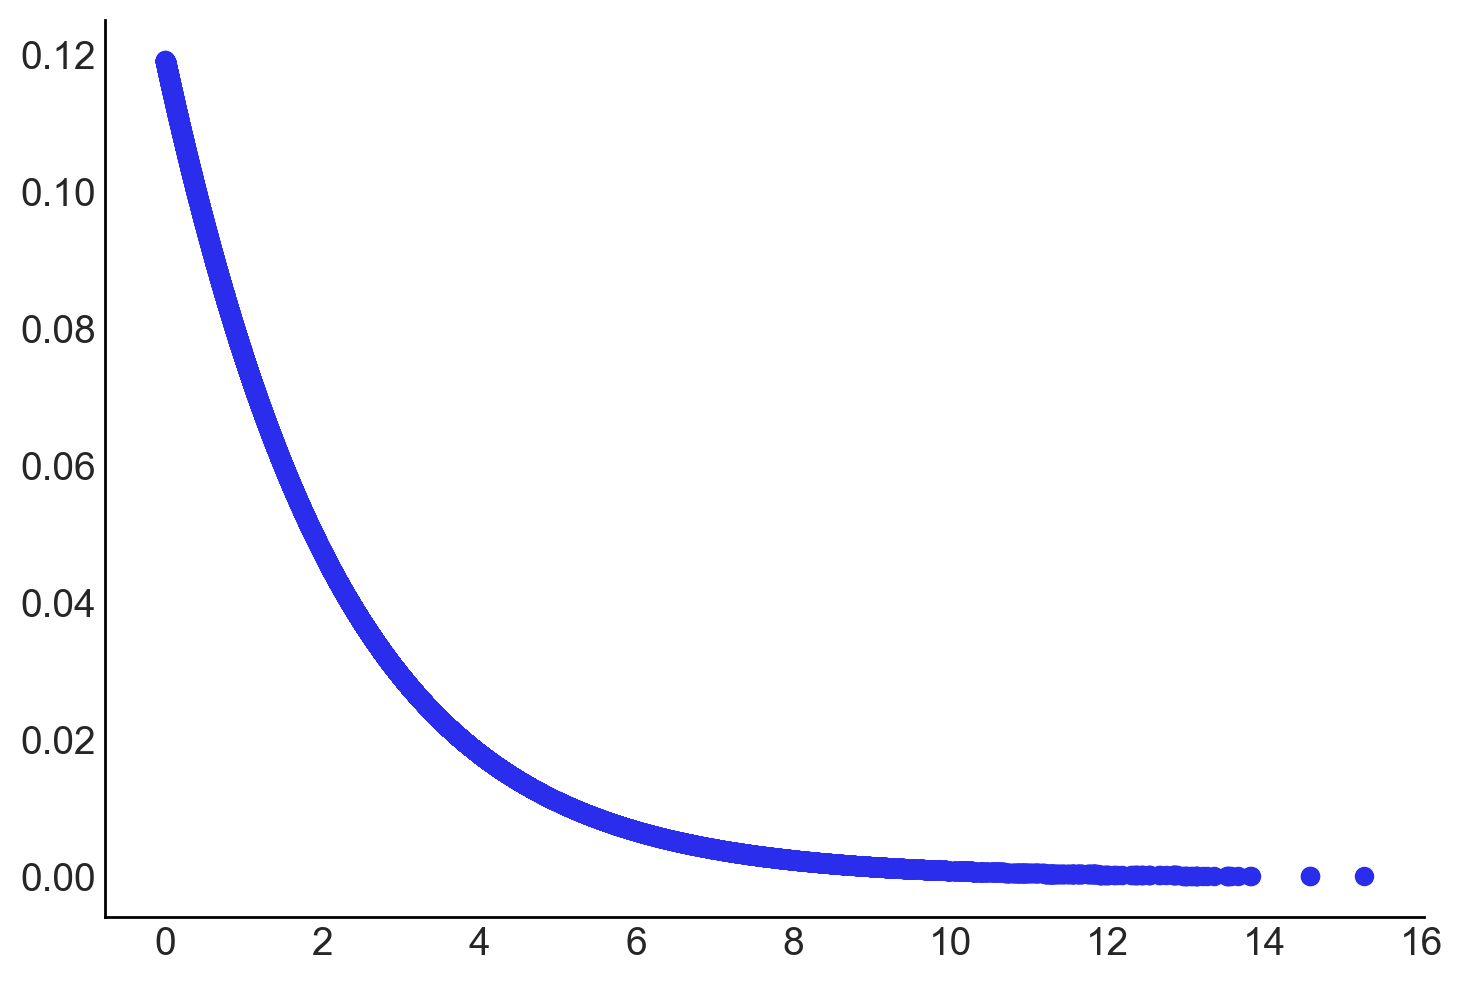

In [5]:
n=300
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
x2 = rng.binomial(n=1,p=0.25,size=n)

x_diff = []
x2_equal =[]
for i in range(n):
    for j in range(i+1,n):
        x_diff.append(np.abs(x[i]-x[j]))
        x2_equal.append(x2[i]==x2[j])
x_diff = np.array(x_diff)
x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
beta = -2, -.5 
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
probs = expit(beta[0] + beta[1]*x_diff)

plt.scatter(x_diff,probs)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]



(array([ 4., 16., 44., 36., 65., 68., 35., 24.,  7.,  1.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

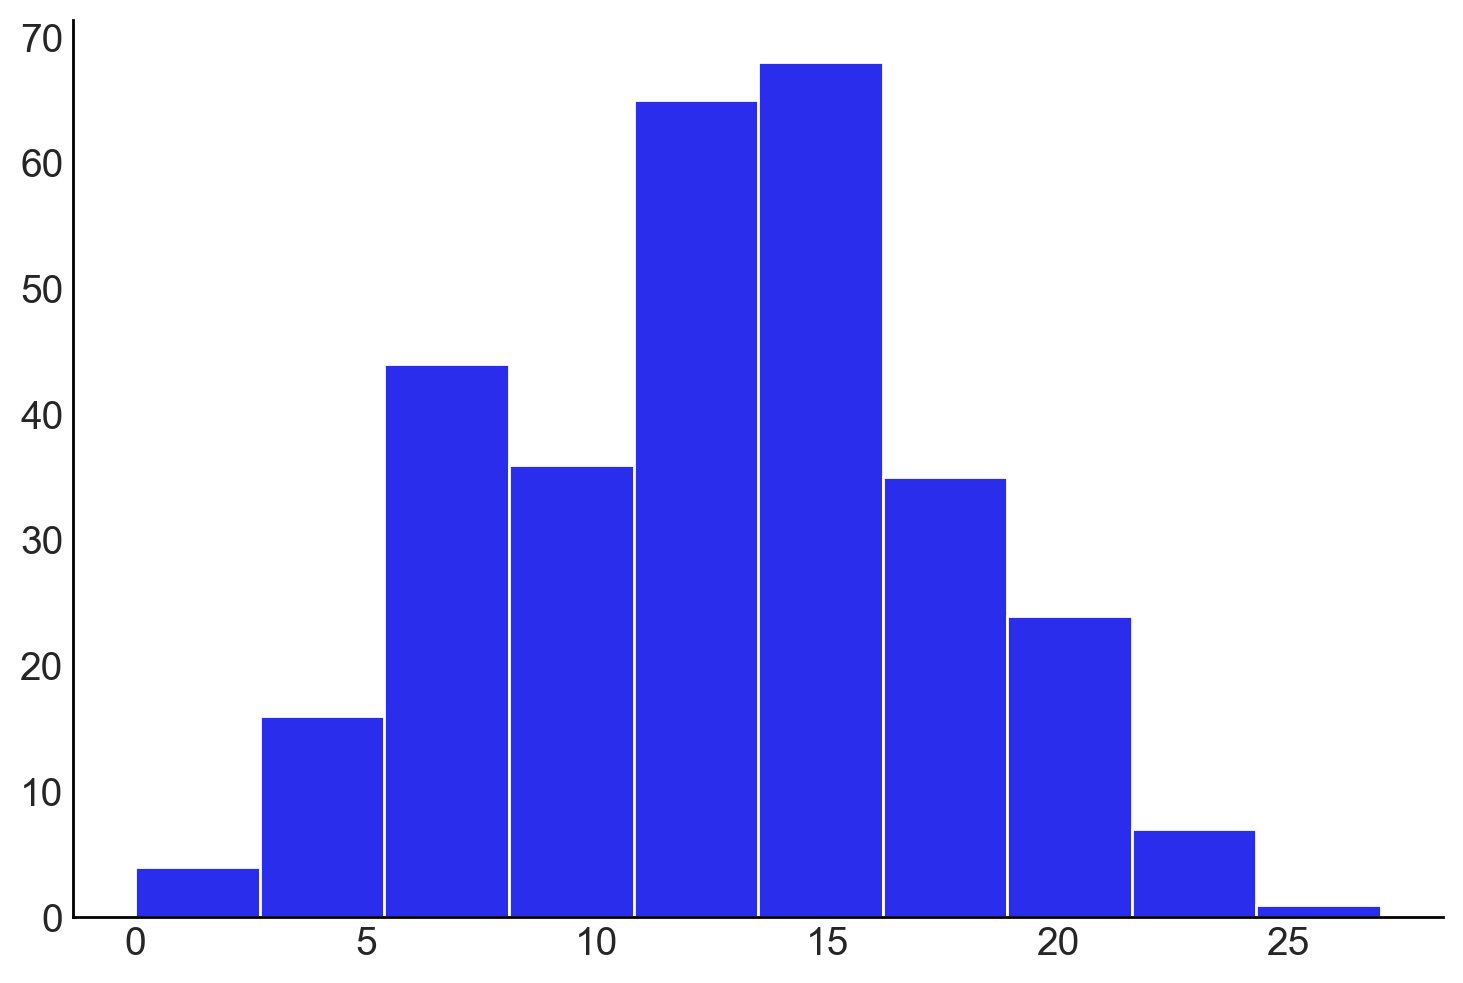

In [6]:
plt.hist(np.sum(mat,1))

                0
count  300.000000
mean     3.400000
std      2.006678
min      0.000000
25%      2.000000
50%      3.000000
75%      5.000000
max     10.000000


(array([ 7., 15., 37., 52., 56., 50., 41., 23., 12.,  7.]),
 array([-3.49827794, -2.47574579, -1.45321363, -0.43068148,  0.59185067,
         1.61438282,  2.63691498,  3.65944713,  4.68197928,  5.70451144,
         6.72704359]),
 <BarContainer object of 10 artists>)

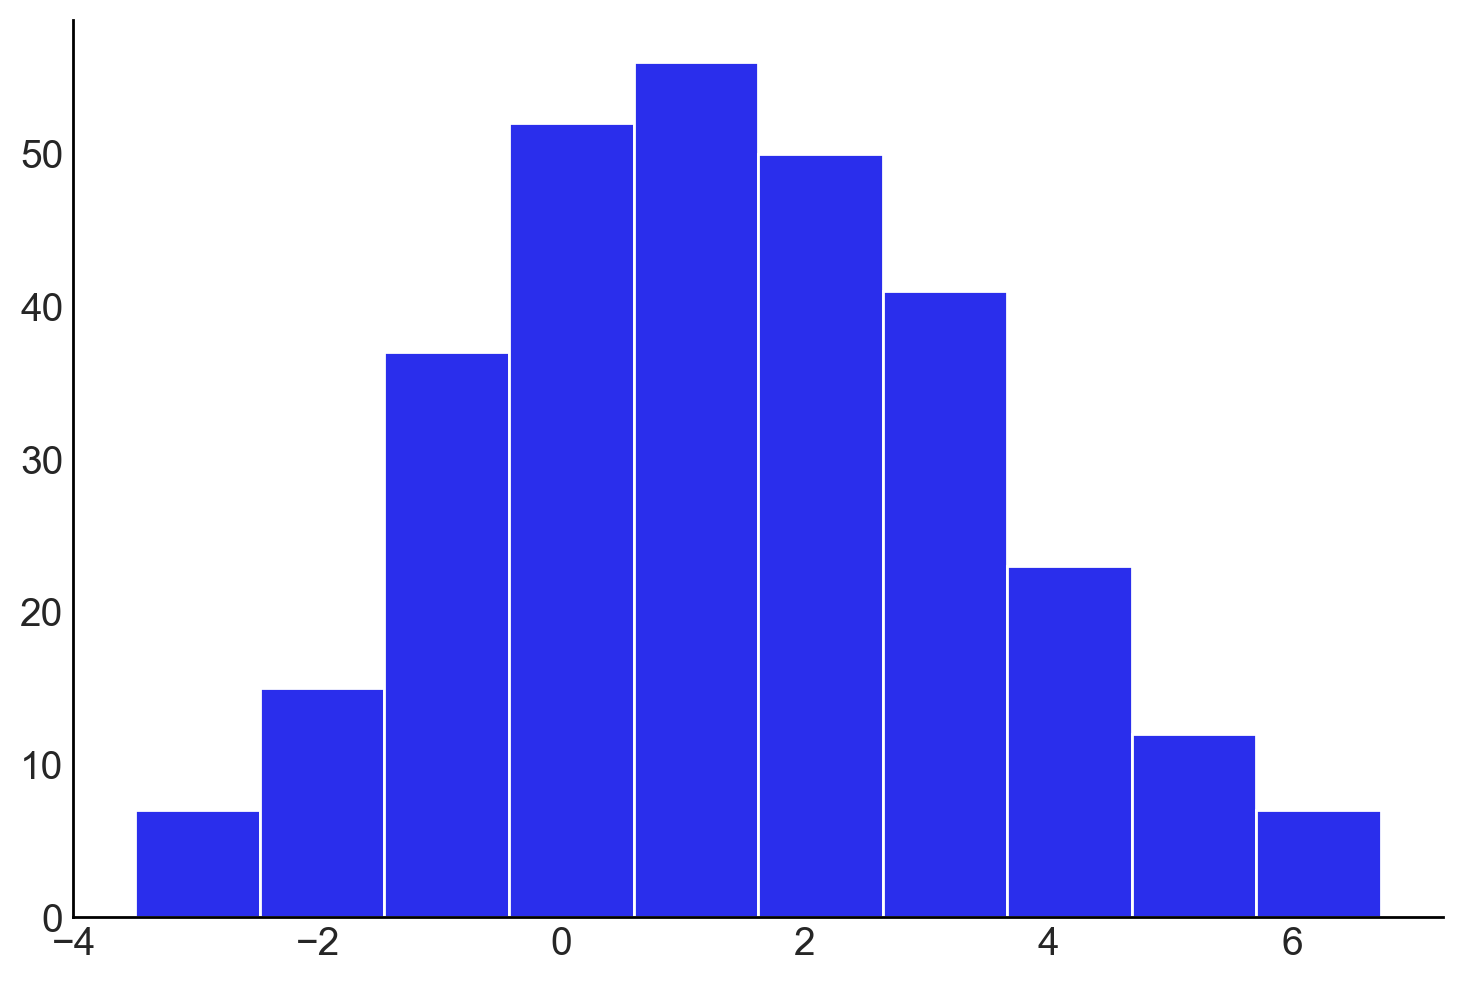

In [7]:
# Create outcome data

Z = rng.binomial(n=1,p=0.3,size=n)
# print(Z)
# print(np.dot(mat,Z)/np.sum(mat,1))
# print(np.dot(mat,Z))
# true_deg = np.sum(mat,1)
# exposures = np.dot(mat,Z)/np.sum(mat,1) > 0.5
# print(pd.DataFrame(exposures).value_counts())

# exposures = np.dot(mat,Z)
# exposures = np.dot(mat,Z)/np.sum(mat,1)

# sum_expos = np.dot(mat,Z)
deg = np.sum(mat,1)
# exposures = np.where(np.equal(deg,0), 0, sum_expos/deg)
exposures = np.dot(mat,Z) 
print(pd.DataFrame(exposures).describe())

# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
alpha = -1, 3, 0.5, -.25

# exposures = np.dot(mat,Z)
# Y = -0.5 + 1.5*Z + 3*exposures + 0.5*(exposures**2) + rng.normal(loc=0,scale=2,size=n)
# Y = -0.5 + 1.5*Z + 3*exposures + rng.normal(loc=0,scale=2,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*Z*exposures + rng.normal(loc=0,scale=3,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + rng.normal(loc=0,scale=3,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*exposures*Z + alpha[4]*true_deg + rng.normal(loc=0,scale=5,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*exposures*Z + alpha[4]*true_deg + rng.normal(loc=0,scale=1,size=n)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*true_deg + alpha[4]*x + rng.normal(loc=0,scale=1,size=n)
Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + rng.normal(loc=0,scale=1,size=n)

plt.hist(Y)


In [307]:
# DG = nx.from_numpy_array(mat)
# nx.set_node_attributes(DG, Z, "Treatments") 
# nx.draw(DG, with_labels=True,  node_color = Z)
# plt.legend()
# plt.show()

In [8]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
gamma1 = 0.35  # Remove existing edge with prob `alph`
# gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
gamma0 = 0.05 # add non-existing edge with prob `bet` 

obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
for i in range(0,n): # add noise
    for j in range(i+1,n):
        if mat[i,j] == 1:
            obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
        else:
            obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
            
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


(array([ 5., 21., 44., 72., 79., 46., 19., 10.,  3.,  1.]),
 array([11. , 13.9, 16.8, 19.7, 22.6, 25.5, 28.4, 31.3, 34.2, 37.1, 40. ]),
 <BarContainer object of 10 artists>)

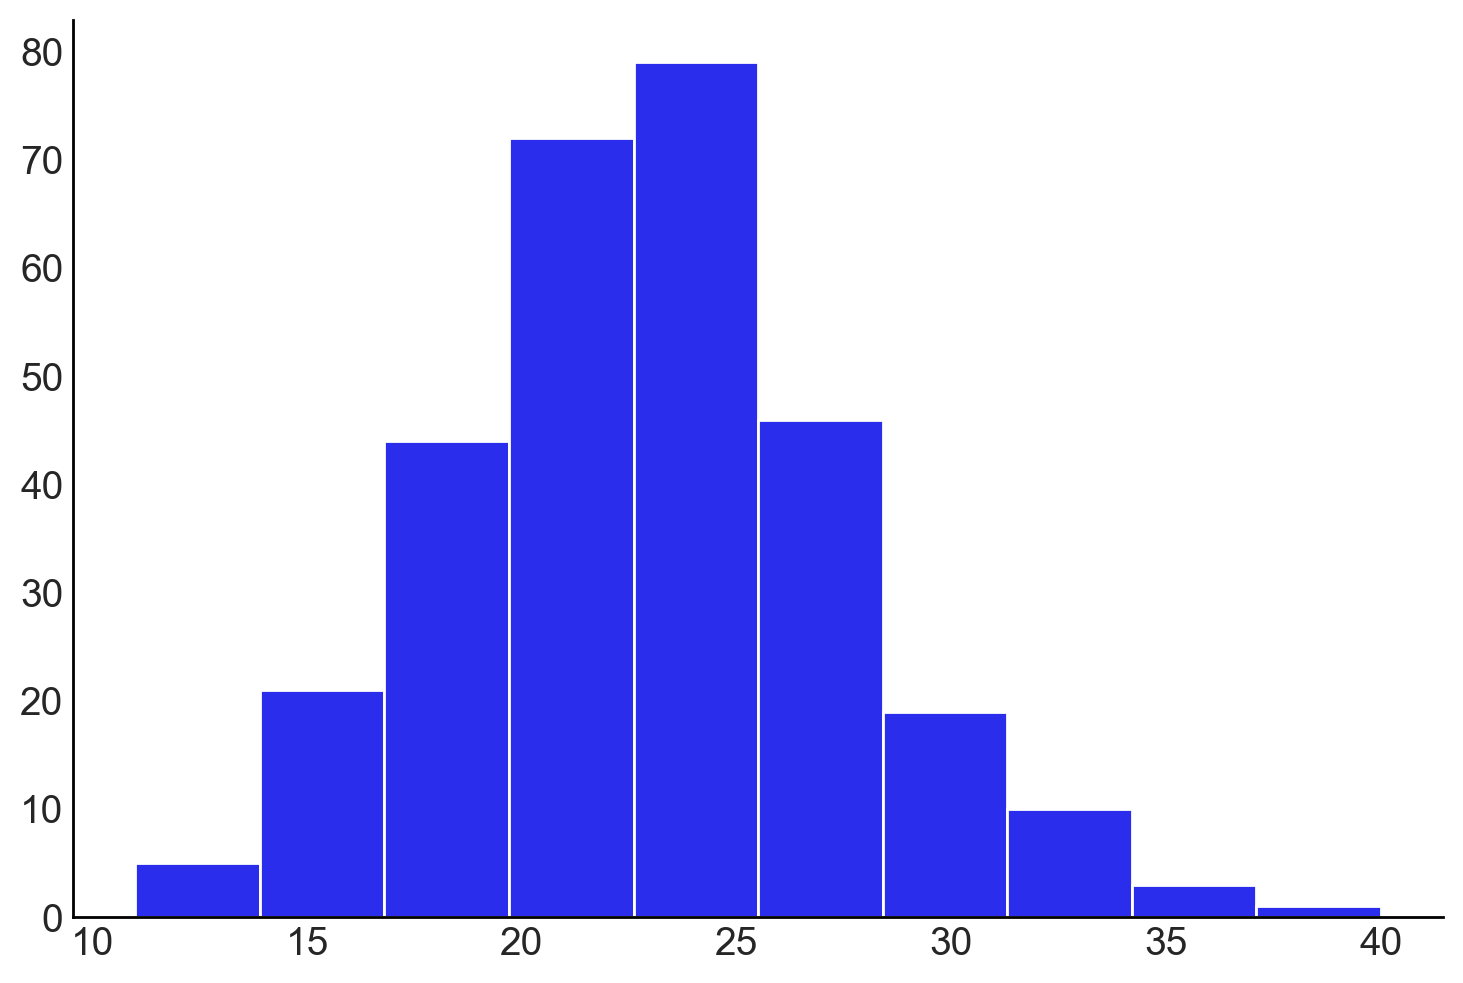

In [9]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.hist(np.sum(obs_mat,1))

In [10]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs'])


obs,0.0,1.0
true,,
0.0,40768,2169
1.0,652,1261


                0
count  300.000000
mean     5.726667
std      2.264741
min      0.000000
25%      4.000000
50%      6.000000
75%      7.000000
max     12.000000
Corr obs~true exposures:  0.47084377202836136


<Axes: >

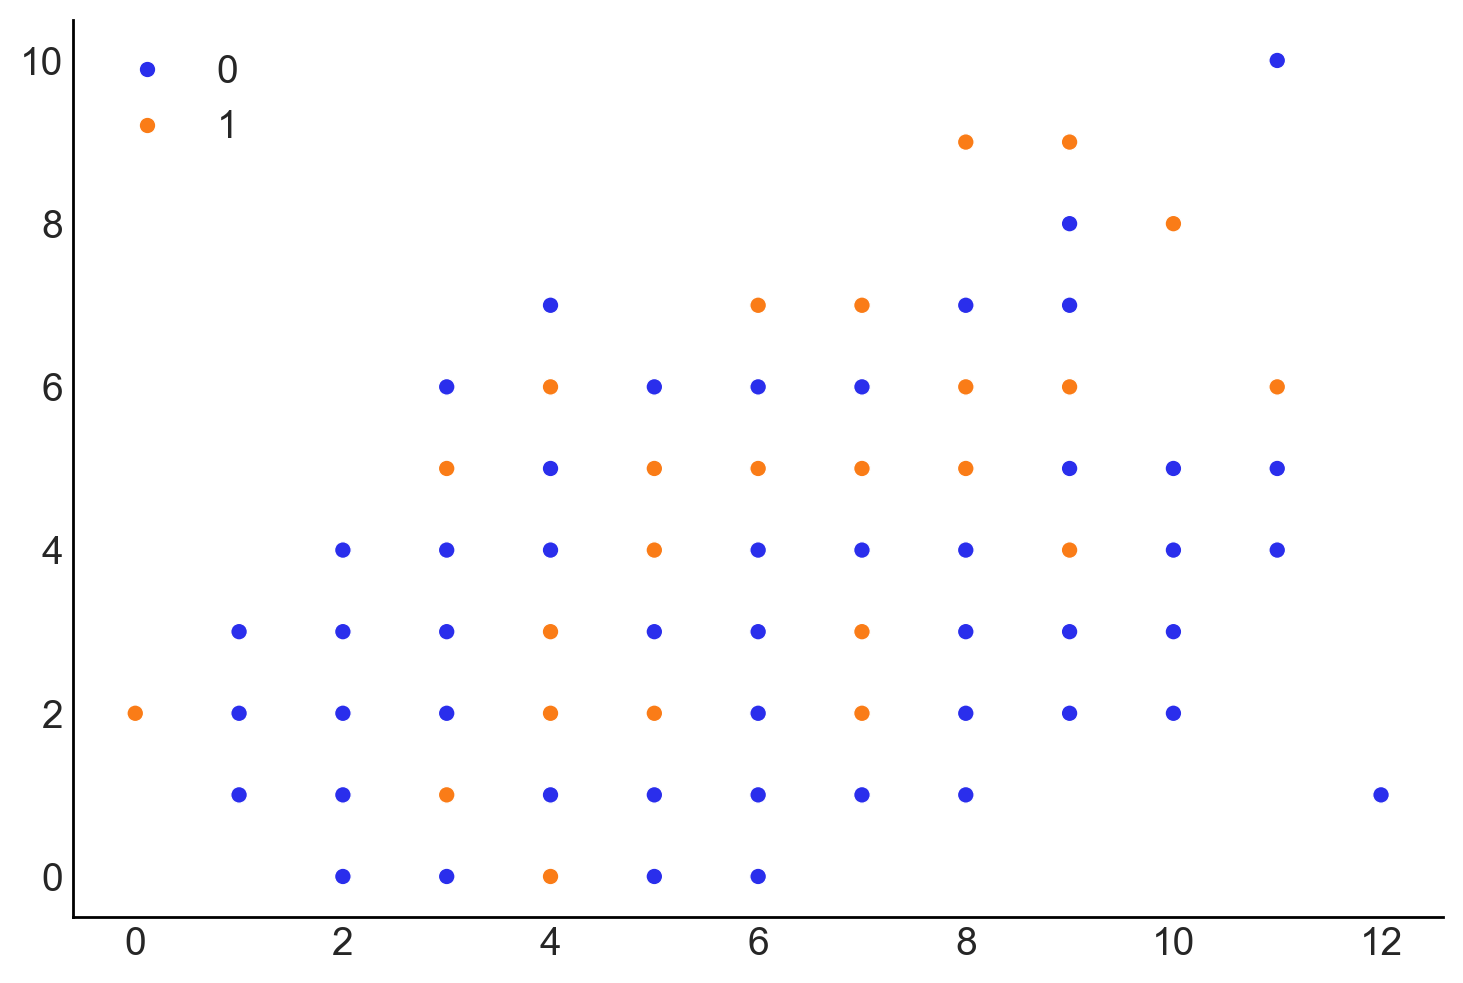

In [11]:

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)

# sum_expos_obs = np.dot(obs_mat,Z)
deg_obs = np.sum(obs_mat,1)
# obs_exposures = np.where(np.equal(deg_obs,0), 0, sum_expos_obs/deg_obs)
obs_exposures = np.dot(obs_mat,Z)

print(pd.DataFrame(obs_exposures).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
sns.scatterplot(x=obs_exposures,y=exposures, hue = Z)

In [312]:
# with pm.Model() as model_obs_mat:
#       # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     # obs_tril = pm.ConstantData("obs_tril", tril_obs)
#     obs_triu = pm.ConstantData("obs_triu", triu_obs)
#     expos = pm.ConstantData("expos", obs_exposures)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob, observed=obs_triu)
#     # tril = pm.Bernoulli("tril", p=prob, observed=obs_tril)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     mu_y = alpha0 + alpha1*z + alpha2*expos +  alpha3*z*expos 
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#       
# pm.model_to_graphviz(model_obs_mat)

In [313]:
# def triu_vals_to_mat(triu_vals, n):
#     # Z_val = Z.eval()
#     triu_vals_ = triu_vals.eval()
#     AM = np.zeros((n,n))
#     AM[np.triu_indices(n=n,k=1)] = triu_vals_
#     # AM[np.tril_indices(n=n,k=-1)] = tril_vals_
#     # AM = AM + AM.T 
#     return AM + AM.T 
#     # return np.dot(AM,Z_val)/np.sum(AM,1)
#     
# # def get_network_miss_prob(tril_vals, gamma0, gamma1):
# #     tril_vals = tril_vals.eval()
# #     obs_tril_prob = 
# 
# with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
#     
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     obs_triu = pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)
#     
#     # Generate net stats
#     A_mat = triu_vals_to_mat(triu,n)
#     expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     deg = pm.Deterministic("deg", pm.math.sum(A_mat,1))
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=5)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=5)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=5)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     sig_y = pm.Exponential("sig_y",lam=.5)
#     mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*deg
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# pm.model_to_graphviz(model)    

In [314]:
# with model:
#     step1 = pm.Metropolis([beta0, beta1, Gamma0, Gamma1, alpha0, alpha1, alpha2, alpha3, sig_y])
#     step2 = pm.BinaryMetropolis([triu])
#     MH_step = pm.CompoundStep([step2, step1])
#     trace = pm.sample(draws=5000, tune=3000, chains=4, cores=4, step=MH_step)
#     # trace = pm.sample(draws=4000, tune=2000, chains=4, cores=4)
#     

In [315]:
# az.summary(trace)

In [316]:
# az.plot_trace(trace)


In [317]:
# with pmx.MarginalModel() as marg_model:      
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     # z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     # y = pm.ConstantData("Y_",Y)
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)  
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)   
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)    
#     # logit model of edges
#     # mu = beta0 + beta1*x + u 
#     # prob = pm.math.invlogit(mu)
#     # Ltri_A_mat = pm.Bernoulli("
#     
#     # Get exposures
#     # expos = tril_vals_to_exposures(obs_tril, z, n)
#     # Lower tri to adj. matrix
#     # A_mat = tril_vals_to_mat(obs_tril,n)
#     # A_mat = triu_vals_to_mat(triu,n)
#     # degress = pm.math.sum(A_mat,1)
#     # sum_expos = pm.math.dot(A_mat,z)
#     # expos = pm.Deterministic("expos", pm.math.switch(pt.tensor.eq(degress,0),0,sum_expos/degress))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z)/pm.math.sum(A_mat,1))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     # # Outcome model
#     # alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     # alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     # alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     # alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     # # alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     # sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*(expos**2)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*z*expos 
#     # Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# marg_model.marginalize(["triu"])
# pm.model_to_graphviz(marg_model)    

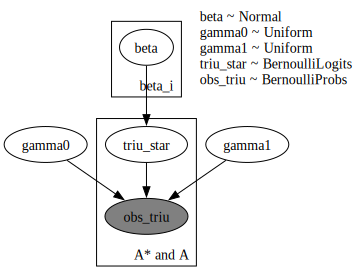

In [12]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_utri = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_utri].set(triu) 
    return adj_mat + adj_mat.T

@config_enumerate
def network_model(X, TriU, n):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,10))
    mu_net = beta[0] + beta[1]*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", triu_n):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 


def outcome_model(Y,Z,X,A,n):
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # sig = numpyro.sample("sig",dist.HalfNormal(scale=5))
    sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("n",n):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)

# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff,triu_obs,n), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))
# TODO: Check different samplers in NumPyro (e.g., HMCwithGibbs, M-HMC, marginalization); They are probably slow, check their runtime and ESS (e.g., in comparison to PyMC).
# TODO: Replace `for` loop with `enumerate`; use `scan` function (see NumPyro HMM guide https://num.pyro.ai/en/stable/examples/hmm_enum.html) see also https://pyro.ai/examples/enumeration.html
# TODO: see also this numpyro guidebook (``rethinking") https://fehiepsi.github.io/rethinking-numpyro/

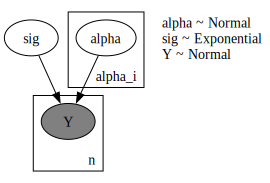

In [13]:
numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)

In [14]:
# A* and A|A* models

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model, dense_mass=True)
kernel_network = NUTS(network_model)
mcmc_network = MCMC(kernel_network, num_warmup=1000, num_samples=3000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -2.17      0.25     -2.20     -2.56     -1.76   3114.66      1.00
   beta[1]     -0.76      0.13     -0.75     -0.99     -0.55   3984.07      1.00
    gamma0      0.06      0.00      0.06      0.05      0.06   4160.21      1.00
    gamma1      0.25      0.14      0.25      0.03      0.48   3388.59      1.00

Number of divergences: 0
229.49006295204163


In [15]:
# Outcome model with A* (true network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.03      0.12     -1.03     -1.23     -0.82   9651.27      1.00
  alpha[1]      2.98      0.14      2.98      2.75      3.20  12552.09      1.00
  alpha[2]      0.48      0.03      0.48      0.43      0.53   9821.80      1.00
  alpha[3]     -0.26      0.02     -0.26     -0.29     -0.22  14121.22      1.00
       sig      1.03      0.04      1.03      0.96      1.10  13919.78      1.00

Number of divergences: 0
6.480260610580444


In [16]:
# Outcome model with A (observed network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.41      0.22     -0.41     -0.75     -0.03   8984.72      1.00
  alpha[1]      3.11      0.18      3.11      2.82      3.41  15499.81      1.00
  alpha[2]      0.17      0.03      0.17      0.12      0.23   9545.46      1.00
  alpha[3]     -0.26      0.03     -0.26     -0.30     -0.21  16496.79      1.00
       sig      1.36      0.06      1.36      1.27      1.45  16717.82      1.00

Number of divergences: 0
8.519097566604614


In [13]:
print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

['beta_0 = -2', 'beta_1 = -0.5'] gamma0: 0.05 gamma1: 0.25
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [17]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)
a_star_pred = Predictive(model=network_model, posterior_samples=post_pred_mean, infer_discrete=True,num_samples=1)
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

(8000, 2)
(8000,)
{'beta': Array([[-2.0021317, -0.7145138]], dtype=float32), 'gamma0': Array([0.058433], dtype=float32), 'gamma1': Array([0.24618678], dtype=float32)}
(1, 44850)
(1, 44850)
False


sec,0,1
first,,
0,42442,953
1,1003,452


In [17]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
post_predictive = post_predictive(rng_key, X=x_diff,TriU=triu_obs,n=n)
samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

(12000, 44850)
(44850,)


In [90]:
NN = n

@jax.jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T

#     AM = np.zeros((NN,NN))
#     AM[np.triu_indices(n=NN,k=1)] = triu_v
#     return AM + AM.T 
# 
# 
# print(np.triu_indices(n=NN,k=1))
# print(a_star_pred1["triu_star"].shape)
# print(a_star_pred1["triu_star"][0])
# 
st = time.time()
for i in range(10000):
    A1 = triu_to_mat(a_star_pred1["triu_star"], n)
print("Regular takes: ", time.time() - st)

st = time.time()
for i in range(10000):
    A2 = Triu_to_mat(a_star_pred1["triu_star"][0])
print("jax.jit takes: ", time.time() - st)

# print(np.array_equal(A1,A2))


Regular takes:  8.094533681869507
jax.jit takes:  3.7990520000457764


(300, 300)
True expos~Y corr: 0.4940616727046689
Pred1 expos~Y corr: 0.31286686835596805
Pred2 expos~Y corr: 0.20336511837137047
obs expos~Y corr: 0.20346648966672973


C:\Users\bar21\AppData\Local\Temp\ipykernel_13756\3047957567.py:12: RuntimeWarning: invalid value encountered in divide
  Pred_expos1 = np.where(np.equal(a_star_pred_deg,0),0,a_star_sum_expos/a_star_pred_deg)
C:\Users\bar21\AppData\Local\Temp\ipykernel_13756\3047957567.py:13: RuntimeWarning: invalid value encountered in divide
  Pred_expos2 = np.where(np.equal(a_star_pred_deg2,0),0,a_star_sum_expos2/a_star_pred_deg2)


Text(0, 0.5, 'True')

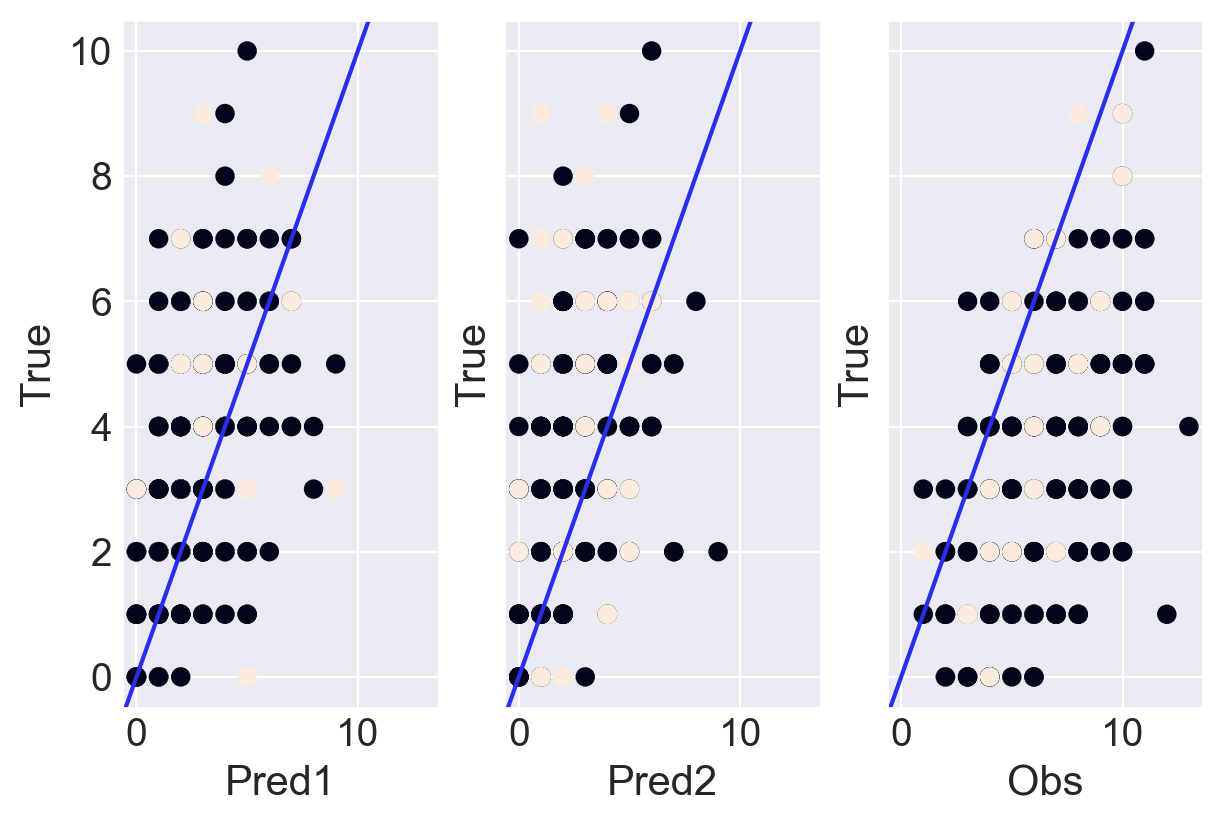

In [83]:

A_star_pred = triu_to_mat(a_star_pred1["triu_star"],n)
A_star_pred2 = triu_to_mat(a_star_pred2["triu_star"],n)
print(A_star_pred.shape)
# print(A_star_pred)


a_star_pred_deg = np.sum(A_star_pred,1)
a_star_pred_deg2 = np.sum(A_star_pred2,1)
a_star_sum_expos = np.dot(A_star_pred,Z) 
a_star_sum_expos2 = np.dot(A_star_pred2,Z)

Pred_expos1 = np.where(np.equal(a_star_pred_deg,0),0,a_star_sum_expos/a_star_pred_deg)
Pred_expos2 = np.where(np.equal(a_star_pred_deg2,0),0,a_star_sum_expos2/a_star_pred_deg2)

print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])
print("Pred1 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos)[1,0])
print("Pred2 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos2)[1,0])
print("obs expos~Y corr:",np.corrcoef(Y,obs_exposures)[1,0])


fig, axes = plt.subplots(nrows=1,ncols=3, sharex=True, sharey=True, figsize = (6,4))
ax1, ax2, ax3 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(a_star_sum_expos, exposures,c = Z+1, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(a_star_sum_expos2, exposures,c = Z+1, marker = 'o')
ax2.axline((0,0),slope=1)
ax3.scatter(obs_exposures, exposures,c = Z+1, marker = 'o')
ax3.axline((0,0),slope=1)
ax1.set_xlabel("Pred1")
ax2.set_xlabel("Pred2")
ax3.set_xlabel("Obs")
ax1.set_ylabel("True")
ax2.set_ylabel("True")
ax3.set_ylabel("True")
# ax.axline((0,0),slope=1)
# ax.set_xlabel("Obs")
# ax.set_ylabel("True")
# plt.show()

In [103]:
# Two-stage with mean posterior of A* and A|A* parameters
def twostage_estimator(MCMC_obj, a_star_pred, Y, Z, X, x_diff, triu_obs, n,i):
    
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=n)
    curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
   
    # pred_exp = np.dot(curr_Astar, Z)
    # print("Pred expos~Y corr:",np.corrcoef(Y,pred_exp)[1,0])
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i**2),Y=Y,Z=Z,X=X, A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()
    
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
    # return xr.DataArray(converted_post_samp)


NN = n

@jax.jit
def get_samples(key, Y, Z, X, A ,n_warmup=500, n_samples=250, n_chains=2):
    kernel_outcome = NUTS(outcome_model)
    mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False)
    mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    return mcmc.get_samples()

def twostage_jj(a_star_pred, Y, Z, X, x_diff, triu_obs, i):
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=NN)
    curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
    # Run MCMC
    curr_posterior_samples = get_samples(random.PRNGKey(i**2), Y, Z, X, curr_Astar)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
     
     
kernel_outcome = NUTS(outcome_model)
mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred_jit = MCMC(kernel_outcome, num_warmup=250, num_samples=500,num_chains=1, progress_bar=False, jit_model_args=True)
# twostage_post_samp = Parallel(n_jobs=4)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n, 100))
print("starting parallel")
print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])

# # 
# start = time.time()
# twostage_post_samp = Parallel(n_jobs=8)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x, x_diff, triu_obs, n,i) for i in tqdm(range(10)))
# # twostage_post_samp = xr.merge(twostage_post_samp)
# twostage_post_samp = pd.concat(twostage_post_samp,axis=0)
# print(twostage_post_samp)
# print("No JIT takes: ", time.time() - start)


start = time.time()
twostage_post_samp_jit = pd.DataFrame()
for i in tqdm(range(50)):
    cur_res = twostage_jj(a_star_pred, Y, Z, x, x_diff, triu_obs,i)
    twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
print(twostage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)



# print(time.time() - start)
# print("starting sequential")
# start = time.time()
# twostage_post_samp2 = [twostage_estimator(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n,i) for i in tqdm(range(20))]
# twostage_post_samp2 = pd.concat(twostage_post_samp2,axis=0)
# print(time.time() - start)

# print(twostage_post_samp)
# print(twostage_post_samp.shape)
# print(twostage_post_samp2)
# print(twostage_post_samp2.shape)

starting parallel
True expos~Y corr: 0.4940616727046689




  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\jax\_src\interpreters\pxla.py:1797: UserWarning: The jitted function get_samples includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  2%|▏         | 1/50 [00:05<04:41,  5.74s/it]

  6%|▌         | 3/50 [00:05<01:12,  1.55s/it]

 10%|█         | 5/50 [00:06<00:35,  1.27it/s]

 14%|█▍        | 7/50 [00:06<00:20,  2.06it/s]

 18%|█▊        | 9/50 [00:06<00:13,  3.00it/s]

 22%|██▏       | 11/50 [00:06<00:09,  4.17it/s]

 26%|██▌       | 13/50 [00:06<00:06,  5.46it/s]

 30%|███       | 15/50 [00:06<00:05,  6.83it/s]

 34%|███▍      | 17/50 [00:06<00:04,  8.12it/s]

 38%|███▊      | 19/50 [00:07<00:03,  9.12it/s]

 42%|█

     iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
0       0  1.259632 -1.176081  3.084287  0.288979 -0.272314
1       0  1.363315 -1.316568  3.008688  0.291085 -0.271799
2       0  1.349631 -1.012168  2.962812  0.288732 -0.274554
3       0  1.245090 -1.017139  2.964402  0.234844 -0.236518
4       0  1.392145 -1.209412  3.254334  0.256554 -0.278530
..    ...       ...       ...       ...       ...       ...
495    49  1.360119 -1.028102  3.299633  0.291270 -0.259443
496    49  1.313506 -1.180850  2.957217  0.260248 -0.258488
497    49  1.354777 -1.231655  3.089585  0.277213 -0.240575
498    49  1.378093 -1.201915  3.129320  0.294912 -0.241510
499    49  1.397625 -1.282988  3.143367  0.278173 -0.262136

[25000 rows x 6 columns]
with JIT (non parallel) takes:  9.71915078163147


(500000, 6)
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1
              iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
mean    499.500000  1.331385 -1.077146  3.038522  0.260445 -0.253838
std     288.675279  0.058850  0.162572  0.186195  0.053564  0.028504
median  499.500000  1.329558 -1.077465  3.038950  0.260382 -0.253791
q005      4.995000  1.189967 -1.494668  2.556904  0.123122 -0.327492
q025     24.975000  1.220951 -1.394909  2.672577  0.155838 -0.309829
q975    974.025000  1.451681 -0.757618  3.402846  0.365944 -0.197978
q995    994.005000  1.493436 -0.657081  3.517233  0.399428 -0.180208
min       0.000000  1.089511 -1.775145  2.137005 -0.002522 -0.388606
max     999.000000  1.672677 -0.275701  4.202640  0.503964 -0.125348


(array([2.80000e+01, 5.83000e+02, 8.76800e+03, 5.53250e+04, 1.49299e+05,
        1.74976e+05, 8.91180e+04, 1.97730e+04, 2.02300e+03, 1.07000e+02]),
 array([-0.0025224 ,  0.04812621,  0.09877482,  0.14942344,  0.20007205,
         0.25072065,  0.30136928,  0.35201788,  0.40266648,  0.45331511,
         0.50396371]),
 <BarContainer object of 10 artists>)

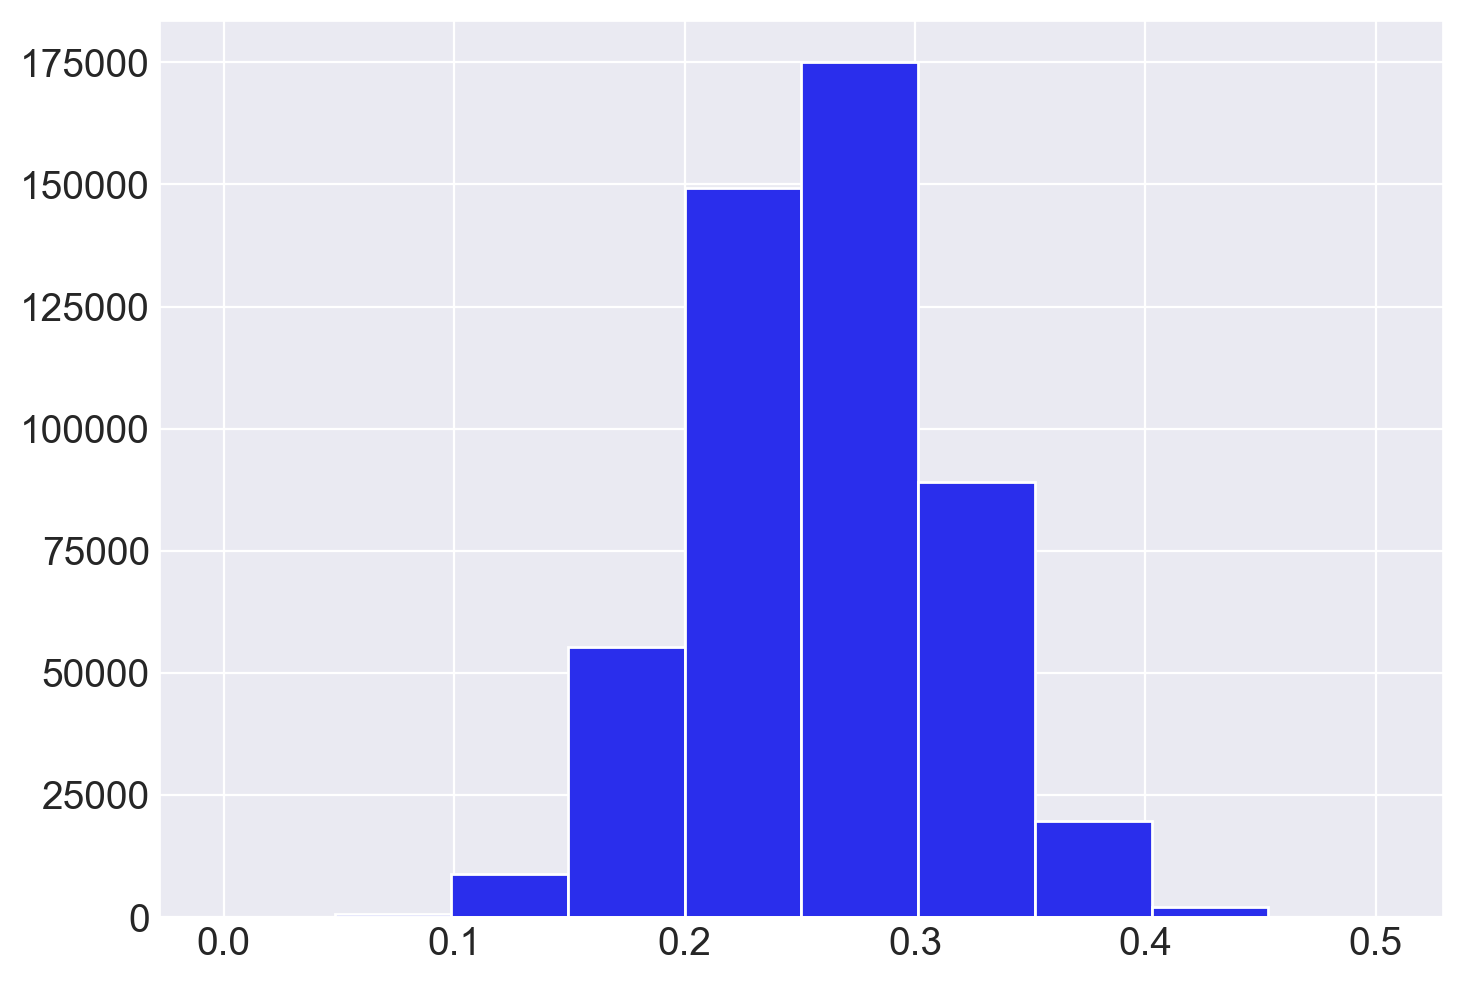

In [100]:
def q025(x):
    return x.quantile(.025)

def q975(x):
    return x.quantile(.975)

def q005(x):
    return x.quantile(.005)

def q995(x):
    return x.quantile(.995)

print(twostage_post_samp_jit.shape)
# print(twostage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:",1)
print(twostage_post_samp_jit.agg(['mean','std','median',q005,q025, q975, q995,'min','max']))


plt.hist(twostage_post_samp_jit["alpha_2"])
# plt.scatter(twostage_post_samp["alpha_2"],twostage_post_samp["alpha_3"])

# TODO: check what is going on in here... we obtain weird results for alpha_2

In [107]:
# Three-stage: for each A* and A|A* param, sample one A*, and sample one (or more) outcome models
def threestage_estimator(MCMC_obj, net_post_samples, Y, Z, X, n, i):

    # sample network
    curr_Astar = triu_to_mat(net_post_samples[i,], n)
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i),Y=Y,Z=Z,X=X,A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()

    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)


def threestage_jj(triu_post_samp, Y, Z, X, i):
    # sample network
    curr_Astar = triu_to_mat(triu_post_samp, NN)
    # Run MCMC
    curr_posterior_samples = get_samples(random.PRNGKey(i), Y, Z, X, curr_Astar)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
     
kernel_outcome = NUTS(outcome_model)
mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 3000)
K = 1000
i_range = np.random.choice(a = range(Astar_post_shape[0]), size = K, replace = False)

# print("starting parallel")
# start = time.time()
# threestage_post_samp = Parallel(n_jobs=8)(delayed(threestage_estimator)(mcmc_network_pred, post_predictive["triu_star"], Y, Z,x, n,i) for i in tqdm(i_range))
# threestage_post_samp = pd.concat(threestage_post_samp,axis=0)
# print(threestage_post_samp)
# print("No JIT time: ", time.time() - start)


start = time.time()
threestage_post_samp_jit = pd.DataFrame()
for i in tqdm(i_range):
# for i in tqdm(range(Astar_post_shape[0])):
    cur_res = threestage_jj(post_predictive["triu_star"][i,], Y, Z, x, i)
    threestage_post_samp_jit = pd.concat([threestage_post_samp_jit, cur_res])    
print(threestage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)






  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:27, 36.29it/s]

  1%|          | 8/1000 [00:00<00:26, 37.10it/s]

  1%|          | 12/1000 [00:00<00:25, 38.14it/s]

  2%|▏         | 16/1000 [00:00<00:27, 35.89it/s]

  2%|▏         | 20/1000 [00:00<00:30, 32.23it/s]

  2%|▏         | 24/1000 [00:00<00:31, 31.13it/s]

  3%|▎         | 28/1000 [00:00<00:33, 28.64it/s]

  3%|▎         | 31/1000 [00:01<00:35, 27.35it/s]

  3%|▎         | 34/1000 [00:01<00:35, 27.45it/s]

  4%|▍         | 38/1000 [00:01<00:33, 28.76it/s]

  4%|▍         | 41/1000 [00:01<00:32, 29.06it/s]

  4%|▍         | 44/1000 [00:01<00:32, 29.24it/s]

  5%|▍         | 47/1000 [00:01<00:32, 29.36it/s]

  5%|▌         | 51/1000 [00:01<00:31, 30.59it/s]

  6%|▌         | 55/1000 [00:01<00:29, 31.82it/s]

  6%|▌         | 59/1000 [00:01<00:29, 32.08it/s]

  6%|▋         | 63/1000 [00:02<00:27, 33.81it/s]

  7%|▋         | 67/1000 [00:02<00:26, 34.93it/s]

  7%|▋         | 71/1000 [00:02<00:26, 3

     iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
0    2028  1.340357 -1.012639  3.304642  0.317222 -0.279416
1    2028  1.300511 -1.068728  3.266553  0.297271 -0.254695
2    2028  1.374632 -0.904924  2.939785  0.300370 -0.260667
3    2028  1.377839 -0.914302  3.079450  0.288237 -0.249469
4    2028  1.427326 -0.918334  3.144017  0.251502 -0.288528
..    ...       ...       ...       ...       ...       ...
495  6421  1.337667 -0.616011  3.151358  0.109837 -0.225144
496  6421  1.325833 -0.556305  3.150955  0.088116 -0.232435
497  6421  1.412384 -1.076555  2.718487  0.321837 -0.293381
498  6421  1.272880 -0.769805  3.174429  0.143057 -0.273648
499  6421  1.241486 -1.009687  3.016699  0.227854 -0.267700

[500000 rows x 6 columns]
with JIT (non parallel) takes:  32.28775358200073


(500000, 6)
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1
               iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
mean    4004.746000  1.331877 -1.083356  3.040554  0.258761 -0.254080
std     2343.814101  0.058375  0.173445  0.188133  0.064964  0.028511
median  4099.500000  1.330105 -1.080258  3.040692  0.254408 -0.254083
q005      19.985000  1.191375 -1.550581  2.552829  0.113692 -0.328063
q025     211.900000  1.222453 -1.432474  2.671827  0.143912 -0.310163
q975    7756.275000  1.451308 -0.751245  3.409037  0.396154 -0.198196
q995    7982.005000  1.492884 -0.650679  3.526491  0.445970 -0.180209
min        1.000000  1.084805 -1.924340  2.169244  0.030153 -0.395600
max     7998.000000  1.654238 -0.317927  4.043899  0.593757 -0.123930


(array([4.52000e+02, 1.14560e+04, 7.92760e+04, 1.62425e+05, 1.44699e+05,
        7.40270e+04, 2.25680e+04, 4.42800e+03, 6.28000e+02, 4.10000e+01]),
 array([0.03015346, 0.08651379, 0.14287412, 0.19923446, 0.25559479,
        0.31195512, 0.36831546, 0.42467579, 0.48103613, 0.53739649,
        0.59375679]),
 <BarContainer object of 10 artists>)

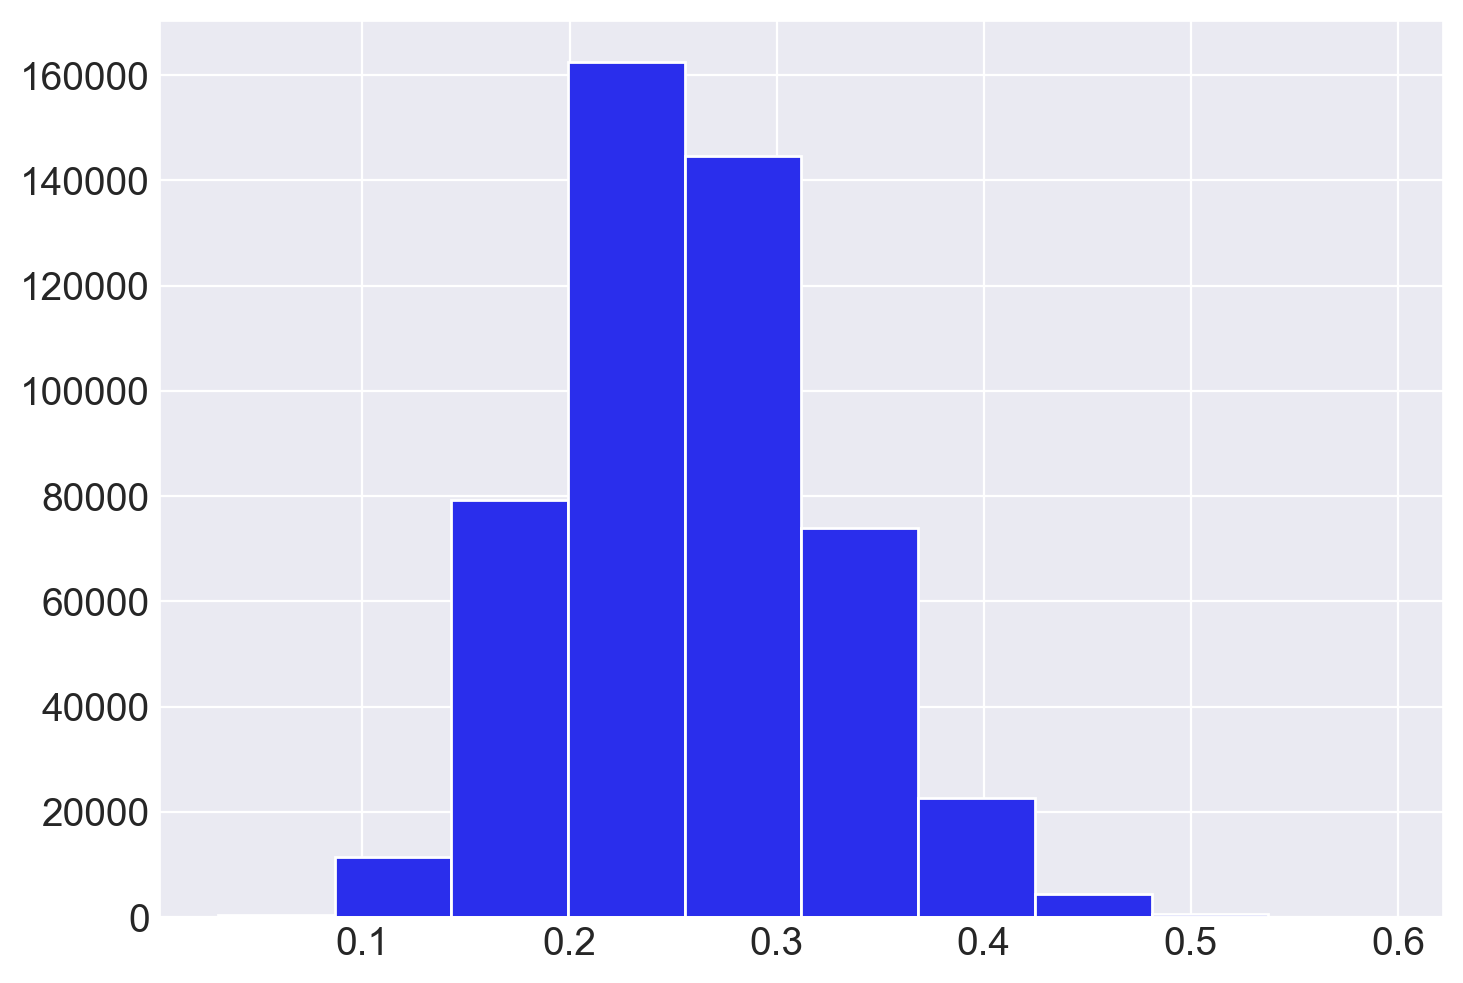

In [108]:
print(threestage_post_samp_jit.shape)
# print(threestage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:", 1)
threestage_post_samp_agg = threestage_post_samp_jit.agg(['mean','std','median',q005,q025, q975,q995,'min','max'])
print(threestage_post_samp_agg)

plt.hist(threestage_post_samp_jit["alpha_2"])

In [376]:
print(threestage_post_samp_agg["alpha_2"]["mean"])
dict_3S = threestage_post_samp_agg["alpha_2"].to_dict()
print(dict_3S)
dict_3S["var_MI"] = 3
print(dict_3S)
dict_3S = {k : dict_3S[k] for k in ["mean","median","var_MI","q025","q975","min","max"]}
print(pd.DataFrame(dict_3S, index = [0]))


0.25162044167518616
{'mean': 0.25162044167518616, 'std': 0.09338366985321045, 'median': 0.2452477067708969, 'q025': 0.08649238757789135, 'q975': 0.45543545410036995, 'min': -0.08816298097372055, 'max': 0.7287529110908508}
{'mean': 0.25162044167518616, 'std': 0.09338366985321045, 'median': 0.2452477067708969, 'q025': 0.08649238757789135, 'q975': 0.45543545410036995, 'min': -0.08816298097372055, 'max': 0.7287529110908508, 'var_MI': 3}
      mean    median  var_MI      q025      q975       min       max
0  0.25162  0.245248       3  0.086492  0.455435 -0.088163  0.728753


In [109]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



VB:  0.0024105507332283457 VW:  0.0018157563  Total var:  0.004228717601189653  Naive var:  0.004220265


In [18]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).
def onestage_estimator(net_post_samples, Z, n, i_range):
    
    deg_list = []
    # sum_expos_list = []
    expos_list = []
    
    for i in i_range:
        # sample network
        curr_Astar = triu_to_mat(net_post_samples[i,], n)
        
        # save statistics
        # c_deg = np.sum(curr_Astar,1)
        # c_sum_expos = np.dot(curr_Astar, Z)
        # c_expos = np.where(np.equal(c_deg,0),0,c_sum_expos/c_deg)
        
        deg_list.append([np.sum(curr_Astar,1)])
        expos_list.append([np.dot(curr_Astar, Z)])
        
        # deg_list.append([c_deg])
        # sum_expos_list.append([c_sum_expos])
        # expos_list.append([c_expos])
    
    return {'deg' : deg_list,
            # 'sum_expos' : sum_expos_list,
            'expos' : expos_list}
        
# i_range = np.random.randint(low=0, high=post_predictive["triu_star"].shape[0],size =5000)
start = time.time()
onestage_net_stat = onestage_estimator(post_predictive["triu_star"], Z, n, range(post_predictive["triu_star"].shape[0]))
print(time.time() - start)
# onestage_net_stat = Parallel(n_jobs=8)(delayed(onestage_estimator)(post_predictive["triu_star"], Z, n,i) for i in tqdm(i_range))
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=1000,num_chains=1, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 1000)


57.87315487861633


deg corr 0.7731224471175862
expos corr 0.6480705690377919
expos (hat) corr Y 0.35196359895353463
expos (true) corr Y 0.49406167270466905


Text(0, 0.5, 'True expos')

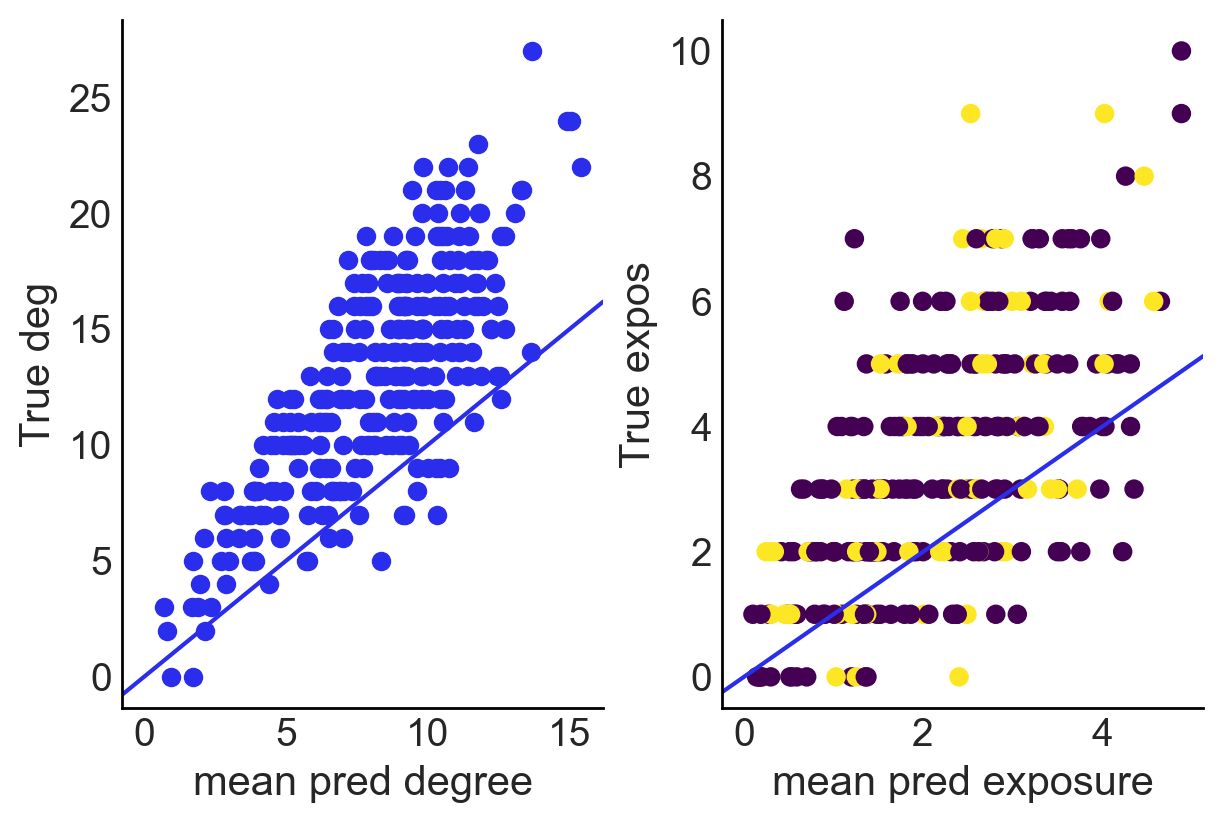

In [19]:
mean_deg = np.mean(onestage_net_stat["deg"],axis=0)
mean_expos = np.mean(onestage_net_stat["expos"],axis=0)
# mean_sum_expos = np.mean(onestage_net_stat["sum_expos"],axis=0)

print("deg corr", np.corrcoef(mean_deg,deg)[1,0])
print("expos corr", np.corrcoef(mean_expos,exposures)[1,0])
print("expos (hat) corr Y", np.corrcoef(mean_expos,Y)[1,0])
print("expos (true) corr Y", np.corrcoef(exposures,Y)[1,0])

fig, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize = (6,4))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(mean_deg, np.sum(mat,1), marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(mean_expos, exposures,c = Z+1, marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred degree")
ax2.set_xlabel("mean pred exposure")
ax1.set_ylabel("True deg")
ax2.set_ylabel("True expos")


Text(0, 0.5, 'True')

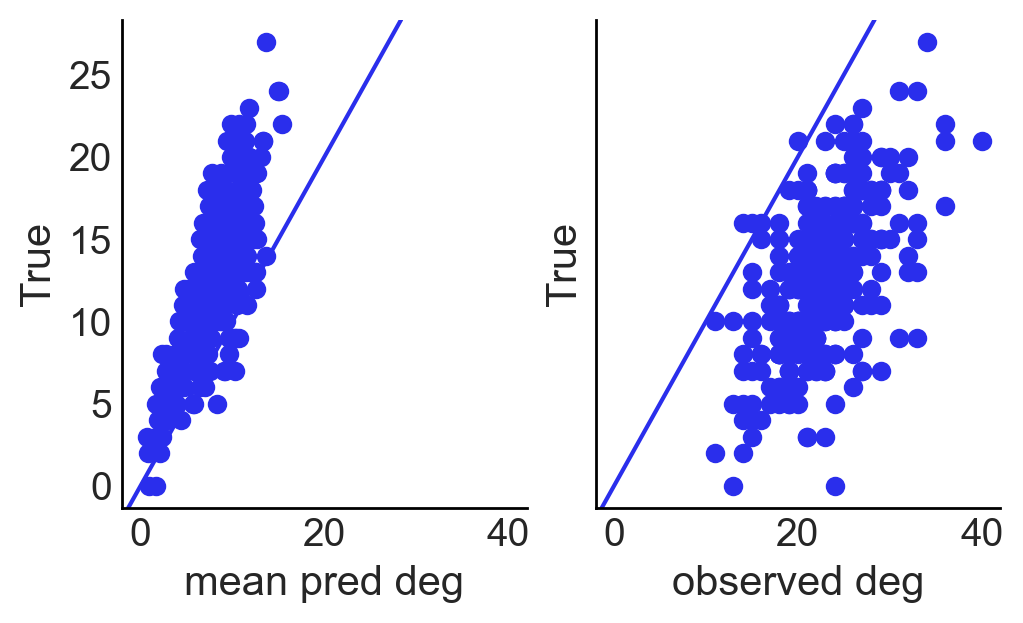

In [20]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True, figsize = (5,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(mean_deg, np.sum(mat,1), marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(np.sum(obs_mat,1), np.sum(mat,1), marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred deg")
ax2.set_xlabel("observed deg")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

Text(0, 0.5, 'True')

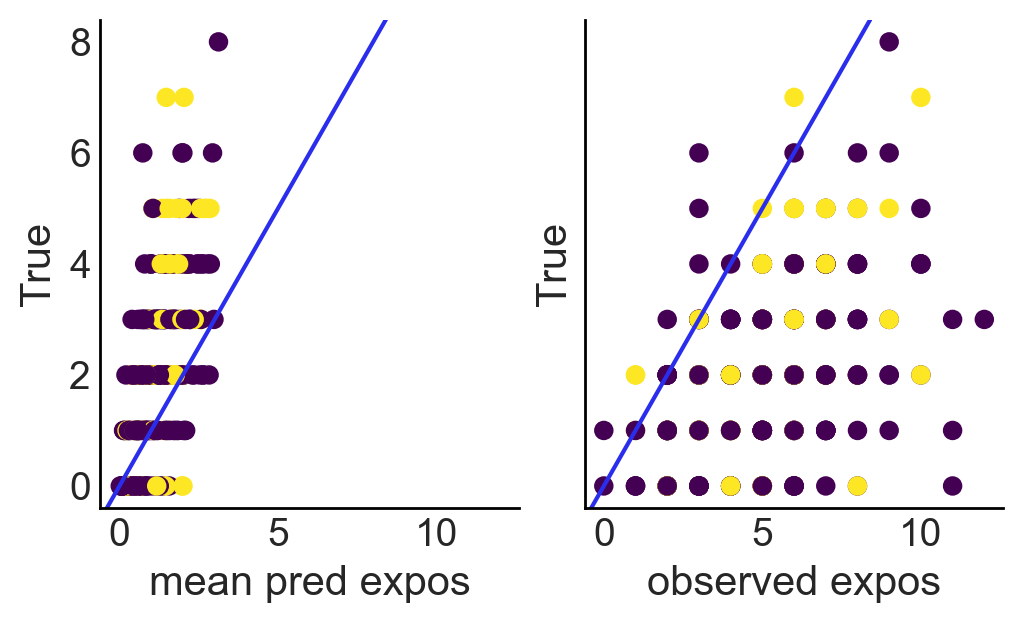

In [336]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True, figsize = (5,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(mean_expos, exposures, c = Z, marker = 'o')
ax1.axline((0,0),slope=1)
ax2.scatter(obs_exposures, exposures,c = Z, marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred expos")
ax2.set_xlabel("observed expos")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

In [337]:
def outcome_stat_model(Y,Z,X,expos,n):
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # sig = numpyro.sample("sig",dist.HalfNormal(scale=5))
    sig = numpyro.sample("sig",dist.Exponential(0.5))
    # expos = jnp.dot(A,Z) / jnp.sum(A,1)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("n",n):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)

# TODO: seems like this is the best option ATM... 
# TODO: 1. check how to represent ICAR (or CAR) models (a la spatial reg) with suffiecent statistics 


In [338]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
kernel_stat_outcome = NUTS(outcome_stat_model)
mcmc_network_stat = MCMC(kernel_stat_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_stat.run(rng_key_,Y=Y,Z=Z,X=x,expos=mean_expos,n=n)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_stat.print_summary()
samples_network_stat = mcmc_network_stat.get_samples()
print(time.time() - start)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.89      0.14     -1.89     -2.12     -1.65  10287.82      1.00
  alpha[1]      3.05      0.16      3.05      2.80      3.31  13526.62      1.00
  alpha[2]      0.70      0.10      0.70      0.55      0.87  10795.87      1.00
  alpha[3]     -0.24      0.03     -0.24     -0.28     -0.20  14734.99      1.00
       sig      1.19      0.05      1.19      1.11      1.27  15103.55      1.00

Number of divergences: 0
4.517497777938843
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [339]:
# dims = {"X": ["time"], "TriU": ["time"]}
# idata_kwargs = {"dims": dims, "constant_data": {"X": x_diff, "TriU": triu_obs}}
# trace_data = az.from_numpyro(mcmc, **idata_kwargs)
# trace_data = az.from_numpyro(posterior=mcmc_network, posterior_predictive=post_predictive,)
# display(trace_data)
# az.plot_trace(trace_data, compact=True)

In [340]:
# posterior_mu = jnp.expand_dims(samples["beta0"],-1) + jnp.expand_dims(samples["beta1"],-1)*x_diff

# print(posterior_mu.shape)
# print(posterior_mu[0:5,0:5])

# fix, ax = plt.subplots(nrows=1,ncols=1, figsize = (5,5))
# ax.plot(beta[0] + beta[1]*x_diff, posterior_mu.mean(axis=0), "o")


In [341]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_triu = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_triu].set(triu) 
    return adj_mat + adj_mat.T

def model_discrete(Y, Z, X, TriU, n):
    # Network model
    beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    mu_net = beta_0 + beta_1*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    
    # temp = numpyro.sample("temp", dist.Uniform(low=0,high=1))
    
    with numpyro.plate("A* and A",triu_n):
        # logp of A* 
        triu_star = numpyro.sample("triu_star",dist.BernoulliLogits(logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=.5,logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=temp,logits=mu_net))
        # # logp of A|A*
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        # prob_misspec = jnp.where(tril_star==1, 1-gamma1, gamma0)
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
       
    # get Astar the symmetric matrix from lower triangle values `tril_var`
    Astar = numpyro.deterministic("Astar", triu_to_mat(triu_star,n))
    # Compute exposures (Astar*Z / d)
    degrees = jnp.sum(Astar,1)
    # num_expos = jnp.dot(Astar,Z)
    # expos = numpyro.deterministic("expos", jnp.where(degress==0,0,num_expos/degrees))
    expos = numpyro.deterministic("expos", jnp.nan_to_num(jnp.dot(Astar,Z)/jnp.sum(Astar,1),nan=0.0))
       
    
    # Outcome model
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    sig = numpyro.sample("sig", dist.Exponential(0.5))
    mu = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*degrees
    with numpyro.plate("n",n):
        numpyro.sample("Y",dist.Normal(mu,sig),obs=Y)
        
    
        


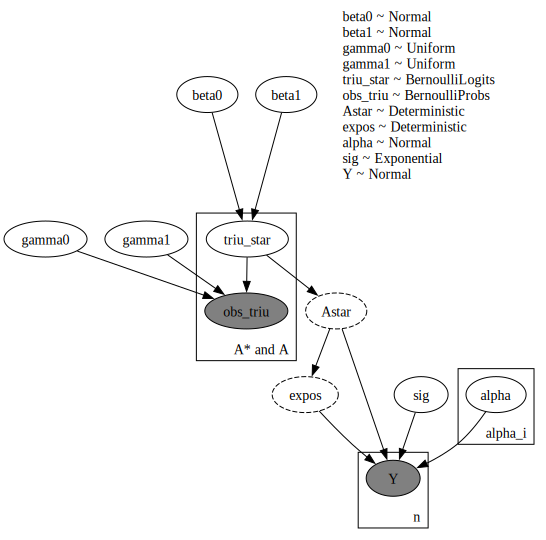

In [342]:
numpyro.render_model(model_discrete, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)


In [343]:
# # Sample from relaxed model
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# # kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model_relaxed)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc.print_summary()
# samples = mcmc.get_samples()
# print(time.time() - start)

In [344]:
print("beta 0:", beta[0], "beta1:", beta[1], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)


beta 0: -2.5 beta1: -0.5 gamma0: 0.049999999999999996 gamma1: 0.3
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [345]:
# Sample from discrete model with mixedHMC
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.2), num_discrete_updates=tril_dim//6)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=1000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [346]:
# Sample from discrete model with NwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [347]:
# Sample from discrete model with HwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(HMC(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)